# Employee Churn Prediction

This notebook predicts employee attrition using HR analytics data. It explores key factors behind employee churn and applies various machine learning models.

## Business Impact
High employee turnover increases hiring, onboarding, and training costs. For example, reducing attrition by just 10% in a 1,000-person company could save ₹5–10 lakhs/month. This model helps HR proactively identify high-risk employees for early intervention.

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pickle

import warnings
warnings.filterwarnings('ignore')

In [269]:
df = pd.read_csv('/content/HR_Dataset.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Overview

In [270]:
df.shape

(14999, 10)

In [271]:
df.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
6088,0.61,0.41,3,103,2,0,0,0,technical,high
8782,0.57,0.95,4,176,3,0,0,0,technical,high
7739,0.61,0.95,4,191,2,0,0,0,hr,low
8389,0.66,0.85,6,165,5,0,0,0,product_mng,medium
2429,0.47,0.86,4,169,6,0,0,0,IT,low


In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Departments            14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [273]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


## Exploratory Data Analysis

In [274]:
df_copy = df.copy()
df_copy.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Departments ', 'salary'],
      dtype='object')

In the above output we can see there's extra space after departments

In [275]:
df_copy.isnull().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
Departments,0
salary,0


Removing extra space as well as lowercasing it

In [276]:
df_copy.rename(columns={'Departments ':'departments'},inplace=True)

In [277]:
df_copy.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,departments,salary
5811,0.55,0.70,3,237,4,0,0,0,sales,low
7981,0.57,0.89,4,255,3,1,0,0,technical,low
6227,0.76,0.99,2,183,2,0,0,0,technical,low
5058,0.67,1.00,4,145,3,1,0,1,sales,medium
11136,0.88,0.91,4,233,4,0,0,0,technical,high


In [278]:
df_copy.duplicated().any()

np.True_

In [279]:
df_copy[df_copy.duplicated()]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,departments,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


Lets drop 3008 rows as they are duplicates

In [280]:
df_copy = df_copy.drop_duplicates()
df_copy.shape

(11991, 10)

We will predcict whether employee will leave or stay (left column)

In [281]:
df_copy['left'].value_counts()

,count
left,
0,10000
1,1991


we can see imbalanced dataset

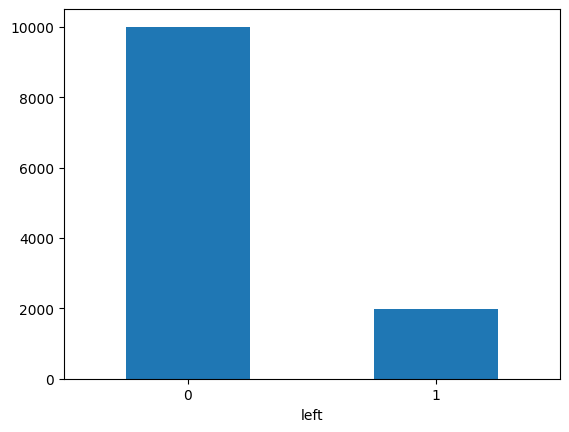

In [282]:
df_copy['left'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

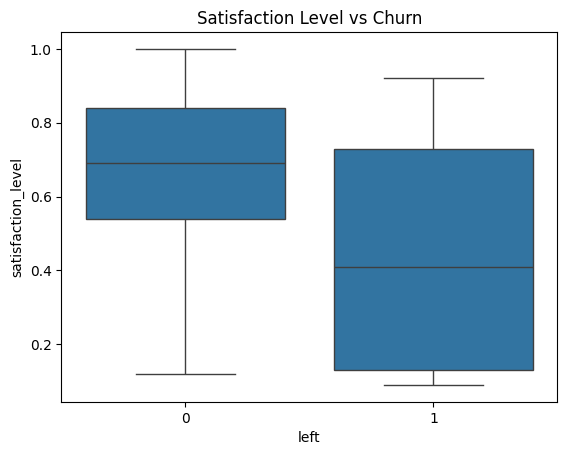

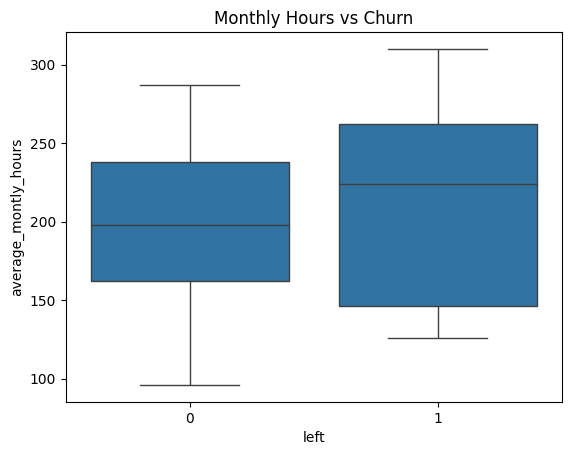

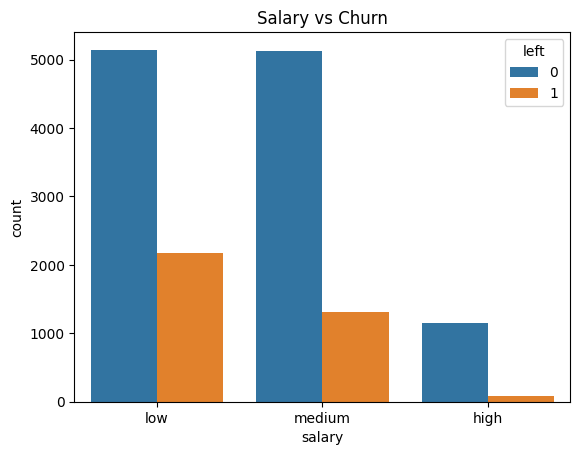

In [283]:
sns.boxplot(x='left', y='satisfaction_level', data=df)
plt.title('Satisfaction Level vs Churn')
plt.show()

sns.boxplot(x='left', y='average_montly_hours', data=df)
plt.title('Monthly Hours vs Churn')
plt.show()

sns.countplot(x='salary', hue='left', data=df)
plt.title('Salary vs Churn')
plt.show()

## Class Imbalance Handling and Model training

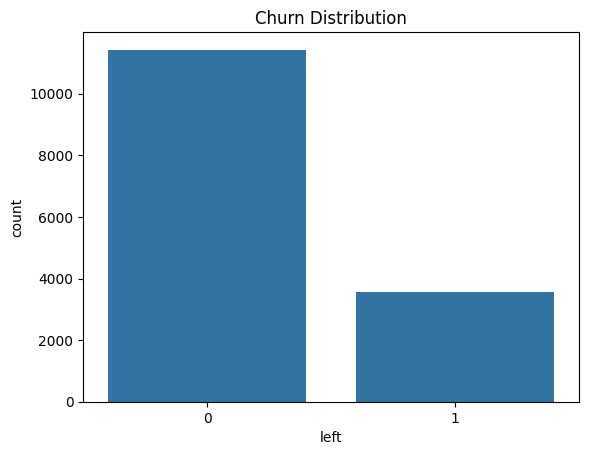

left
0    76.191746
1    23.808254
Name: proportion, dtype: float64


In [284]:
sns.countplot(x='left', data=df)
plt.title('Churn Distribution')
plt.show()

print(df['left'].value_counts(normalize=True) * 100)

Fixing the class imbalance :

I need to convert the columns salary and departments for smote, but i am also onehotencoding in the pipeline, so i'll make a copy of df_copy and use it (or i can also use  stratify=y during train test split, which also deals with class imbalance)

In this case, after trial and error stratify = y turns out to be a better way to predict, because class imbalance is not extremely large

Taking columns with only number data types like float and int

In [285]:
int_cols = df_copy.select_dtypes(include=['int64', 'float64']).columns.to_list()
int_cols.remove('left')
int_cols

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years']

Now lets standardize and encode the required text columns

In [286]:
preprocessor = ColumnTransformer(transformers=[
    ('num',StandardScaler(),int_cols),
    ('nominal',OneHotEncoder(),['departments']),
    ('ordinal',OrdinalEncoder(),['salary'])
],remainder='passthrough')

First lets work with only linear regression

In [287]:
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('model',LogisticRegression())
])

In [288]:
from sklearn import set_config

set_config(display='diagram')

In [289]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['satisfaction_level',
                                                   'last_evaluation',
                                                   'number_project',
                                                   'average_montly_hours',
                                                   'time_spend_company',
                                                   'Work_accident',
                                                   'promotion_last_5years']),
                                                 ('nominal', OneHotEncoder(),
                                                  ['departments']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['salary'])])),
                ('model', LogisticRegression())])

In [293]:
X = df_copy.drop('left',axis=1)
y = df_copy['left']

In [294]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

In [295]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['satisfaction_level',
                                                   'last_evaluation',
                                                   'number_project',
                                                   'average_montly_hours',
                                                   'time_spend_company',
                                                   'Work_accident',
                                                   'promotion_last_5years']),
                                                 ('nominal', OneHotEncoder(),
                                                  ['departments']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['salary'])])),
                ('model', LogisticRegression())])

In [296]:
y_pred = pipeline.predict(X_test)

In [297]:
print('accuracy_score:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_test,y_pred))
print('recall_score:',recall_score(y_test,y_pred))

accuracy_score: 0.8370154230929554
precision_score: 0.5209580838323353
recall_score: 0.2185929648241206


Making a function for the above steps for predicting scores as well as making pipelines

In [304]:
def model_scorer(model_name,model):

    output=[]

    output.append(model_name)

    pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('model',model)])

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    output.append(accuracy_score(y_test,y_pred))

    output.append(precision_score(y_test,y_pred))

    output.append(recall_score(y_test,y_pred))

    output.append(classification_report(y_test,y_pred))

    output.append(confusion_matrix(y_test,y_pred))

    output.append(roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

    RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f"ROC Curve - {model_name}")
    plt.show()

    return output

In [305]:
model_dict={
    'logistic_regression':LogisticRegression(),
    'decision_tree':DecisionTreeClassifier(),
    'random_forest':RandomForestClassifier(),
    'XGB':XGBClassifier()

}

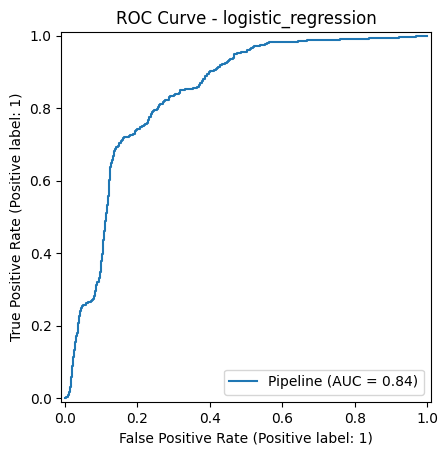

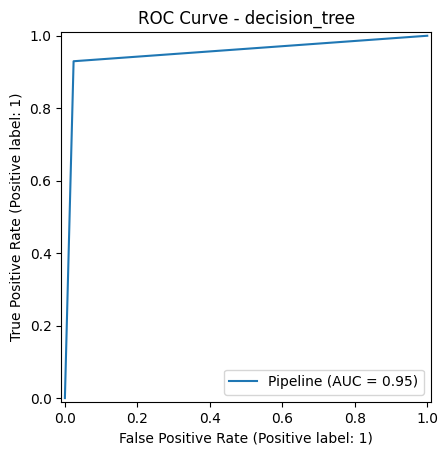

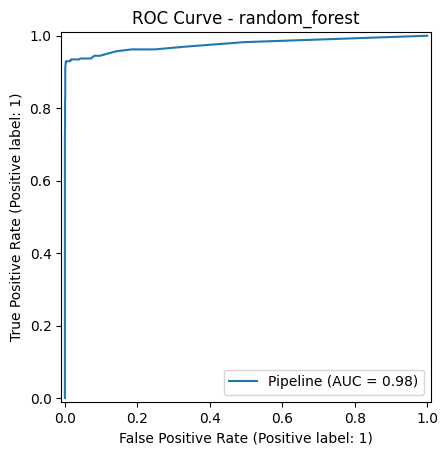

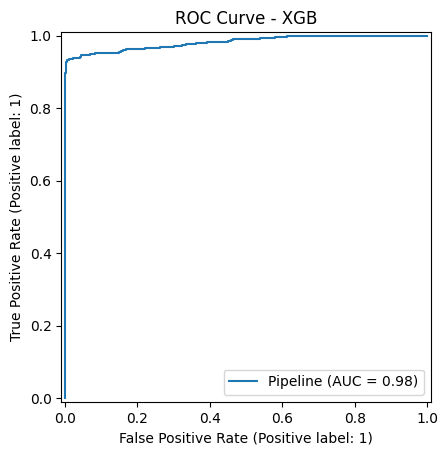

In [315]:
#loop for using all the models by itself
model_output=[]
for model_name,model in model_dict.items():
    model_output.append(model_scorer(model_name,model))

In [316]:
model_results_df = pd.DataFrame(model_output, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'Classification Report', 'Confusion Matrix', 'ROC AUC Score'])
model_results_df

,Model,Accuracy,Precision,Recall,Classification Report,Confusion Matrix,ROC AUC Score
0,logistic_regression,0.837015,0.520958,0.218593,precision recall f1-score ...,"[[1921, 80], [311, 87]]",0.837349
1,decision_tree,0.968320,0.885167,0.929648,precision recall f1-score ...,"[[1953, 48], [28, 370]]",0.952830
2,random_forest,0.985411,0.986595,0.924623,precision recall f1-score ...,"[[1996, 5], [30, 368]]",0.976221
3,XGB,0.983743,0.968668,0.932161,precision recall f1-score ...,"[[1989, 12], [27, 371]]",0.981986


printing the full classification report

In [314]:
for output in model_output:
    model_name = output[0]
    classification_report_str = output[4] # Index 4 contains the classification report string

    print(f"--- Classification Report for {model_name} ---")
    print(classification_report_str)
    print("-" * 30)

--- Classification Report for logistic_regression ---
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2001
           1       0.52      0.22      0.31       398

    accuracy                           0.84      2399
   macro avg       0.69      0.59      0.61      2399
weighted avg       0.80      0.84      0.81      2399

------------------------------
--- Classification Report for decision_tree ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2001
           1       0.89      0.92      0.91       398

    accuracy                           0.97      2399
   macro avg       0.94      0.95      0.95      2399
weighted avg       0.97      0.97      0.97      2399

------------------------------
--- Classification Report for random_forest ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2001
           1       0.99  

#Best model

random forest gives best results so we are gonna use it to make a model andlets standardize and encode it

In [317]:
preprocessor = ColumnTransformer(transformers=[
    ('num',StandardScaler(),int_cols),
    ('nominal',OneHotEncoder(),['departments']),
    ('ordinal',OrdinalEncoder(),['salary'])
],remainder='passthrough')

In [356]:
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('model',RandomForestClassifier())
])

In [357]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['satisfaction_level',
                                                   'last_evaluation',
                                                   'number_project',
                                                   'average_montly_hours',
                                                   'time_spend_company',
                                                   'Work_accident',
                                                   'promotion_last_5years']),
                                                 ('nominal', OneHotEncoder(),
                                                  ['departments']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['salary'])])),
                ('model', RandomForestClassifier())])

In [358]:
import pickle

In [359]:
with open('pipeline.pkl','wb') as f:
    pickle.dump(pipeline,f)


In [360]:
with open('pipeline.pkl','rb') as f:
    pipeline_saved = pickle.load(f)

In [361]:
#now for the test dataset
test_df = pd.read_csv('HR_Dataset_test.csv')

In [362]:
test_df.shape

(9, 9)

In [363]:
test_df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,0,sales,low
1,0.80,0.86,5,262,6,0,0,sales,medium
2,0.11,0.88,7,272,4,0,0,sales,medium
3,0.72,0.87,5,223,5,0,0,sales,low
4,0.98,0.66,5,248,3,0,0,technical,medium
5,0.75,0.70,4,144,4,0,0,technical,high
6,1.00,0.41,4,174,3,0,0,technical,low
7,0.24,0.82,5,179,6,0,0,technical,medium
8,0.84,0.43,6,246,4,0,0,technical,medium


In [364]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     9 non-null      float64
 1   last_evaluation        9 non-null      float64
 2   number_project         9 non-null      int64  
 3   average_montly_hours   9 non-null      int64  
 4   time_spend_company     9 non-null      int64  
 5   Work_accident          9 non-null      int64  
 6   promotion_last_5years  9 non-null      int64  
 7   Departments            9 non-null      object 
 8   salary                 9 non-null      object 
dtypes: float64(2), int64(5), object(2)
memory usage: 780.0+ bytes


In [365]:
test_df.isnull().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
promotion_last_5years,0
Departments,0
salary,0


In [366]:
test_df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'Departments ', 'salary'],
      dtype='object')

In [367]:
test_df = test_df.rename(columns={'Departments ':'departments'})

In [368]:
test_df.duplicated().any()

np.False_

In [369]:
pred_test = pipeline_saved.predict(test_df)

In [370]:
print(pred_test)

[1 1 1 1 0 0 0 0 0]


In [371]:
pred_test_series = pd.Series(pred_test)

In [372]:
pred_test_df = pd.concat([test_df, pred_test_series], axis=1)
pred_test_df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,departments,salary,0
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.98,0.66,5,248,3,0,0,technical,medium,0
5,0.75,0.70,4,144,4,0,0,technical,high,0
6,1.00,0.41,4,174,3,0,0,technical,low,0
7,0.24,0.82,5,179,6,0,0,technical,medium,0
8,0.84,0.43,6,246,4,0,0,technical,medium,0


In [373]:
pred_test_df = pred_test_df.rename(columns={0: 'will_leave'})
pred_test_df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,departments,salary,will_leave
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.98,0.66,5,248,3,0,0,technical,medium,0
5,0.75,0.70,4,144,4,0,0,technical,high,0
6,1.00,0.41,4,174,3,0,0,technical,low,0
7,0.24,0.82,5,179,6,0,0,technical,medium,0
8,0.84,0.43,6,246,4,0,0,technical,medium,0


In [374]:
save = pred_test_df.to_csv('pred_test_df.csv', index=False)

## Deployment-Ready Function

In [375]:
def predict_employee_status(model_pipeline, input_df):
    # Ensure the input is a pandas DataFrame
    if not isinstance(input_df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    # The model_pipeline is expected to be a fitted scikit-learn pipeline and preprocessing steps and the final model.
    # The pipeline's predict method handles the preprocessing automatically.
    predictions = model_pipeline.predict(input_df)

    # 0 for stay, 1 for leave
    return predictions

In [376]:
predictions_on_test_df = predict_employee_status(pipeline_saved, test_df)
print("Predictions for the test dataset:")
print(predictions_on_test_df)
# Adding these predictions back to the test_df DataFrame
test_df['will_leave_predicted'] = predictions_on_test_df
test_df

Predictions for the test dataset:
[1 1 1 1 0 0 0 0 0]


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,departments,salary,will_leave_predicted
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.98,0.66,5,248,3,0,0,technical,medium,0
5,0.75,0.70,4,144,4,0,0,technical,high,0
6,1.00,0.41,4,174,3,0,0,technical,low,0
7,0.24,0.82,5,179,6,0,0,technical,medium,0
8,0.84,0.43,6,246,4,0,0,technical,medium,0


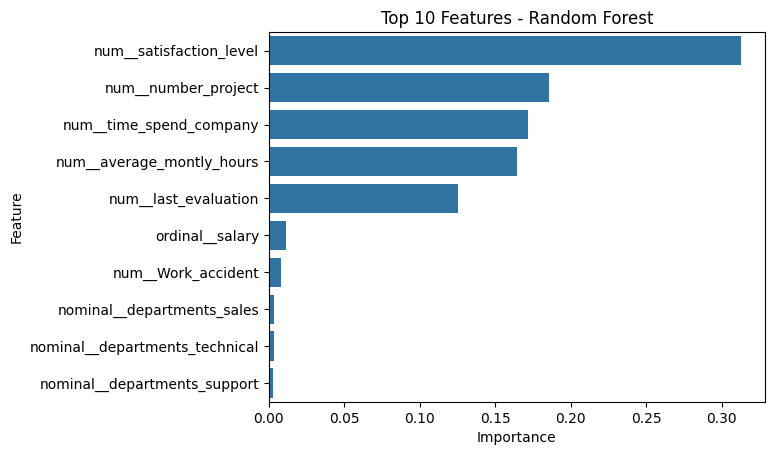

In [377]:
rf_model = model_dict['random_forest']

#Feature importances from the trained model
importances = rf_model.feature_importances_
#from preprocessor (given its fitted)
feature_names_after_preprocessing = preprocessor.get_feature_names_out()
#creating df
importance_df = pd.DataFrame({'Feature': feature_names_after_preprocessing, 'Importance': importances})
#sorting the df by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
#plot
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Features - Random Forest")
plt.show()

## ✅ Conclusion

- Satisfaction, promotion, and workload are key drivers of churn.
- XGBoost and Random Forest outperform Logistic Regression.
- Predictive models can enable HR to proactively retain employees.

**Next Steps**:
- Create a Streamlit web app for HR teams

## Fairness Analysis

To ensure ethical use of this model in HR decision-making, we evaluate fairness across salary levels and departments.

We measure:
- Churn prediction rates across groups
- Accuracy disparities

Significant differences may require adjusting the model or applying fairness constraints.

In [378]:
def group_fairness_report(model_pipeline, X_test_original, y_test_original, group_col):

    print(f"Fairness Report by {group_col}")

    #ensure the group_col exists in the original test data
    if group_col not in X_test_original.columns:
        print(f"Error: Group column '{group_col}' not found in the test data.")
        return

    for group_value in X_test_original[group_col].unique():
        print(f"\n--- Group: {group_col} = {group_value} ---")

        # Filter the original test data for the current group
        group_indices = X_test_original[X_test_original[group_col] == group_value].index
        X_test_group = X_test_original.loc[group_indices]
        y_test_group = y_test_original.loc[group_indices]

        if len(group_indices) == 0:
            print("No samples in this group.")
            continue

        # Make predictions for the current group using the fitted pipeline
        # The pipeline will handle preprocessing for this subset of data
        y_pred_group = model_pipeline.predict(X_test_group)

        # Calculate and print metrics for the group
        acc = accuracy_score(y_test_group, y_pred_group)
        # Precision and Recall might be less stable with very small group sizes
        precision = precision_score(y_test_group, y_pred_group, zero_division=0) # Handle cases with no positive predictions
        recall = recall_score(y_test_group, y_pred_group, zero_division=0)

        print(f"Accuracy = {acc:.3f}")
        print(f"Precision = {precision:.3f}")
        print(f"Recall = {recall:.3f}")
        print(f"Support = {len(group_indices)}")


Now you can use the `group_fairness_report` function to analyze fairness by grouping your test data by a specific column, such as 'salary' or 'departments'.

Make sure you use your fitted pipeline object (e.g., `pipeline_saved` or the pipeline with your chosen best model) and the original `X_test` and `y_test` DataFrames from your `train_test_split`.

In [379]:
# Analyze fairness by 'salary'
group_fairness_report(pipeline_saved, X_test, y_test, group_col='salary')

# Analyze fairness by 'departments'
# group_fairness_report(pipeline_saved, X_test, y_test, group_col='departments')

Fairness Report by salary

--- Group: salary = medium ---
Accuracy = 0.988
Precision = 0.993
Recall = 0.918
Support = 1063

--- Group: salary = low ---
Accuracy = 0.984
Precision = 0.995
Recall = 0.929
Support = 1146

--- Group: salary = high ---
Accuracy = 0.984
Precision = 0.917
Recall = 0.846
Support = 190


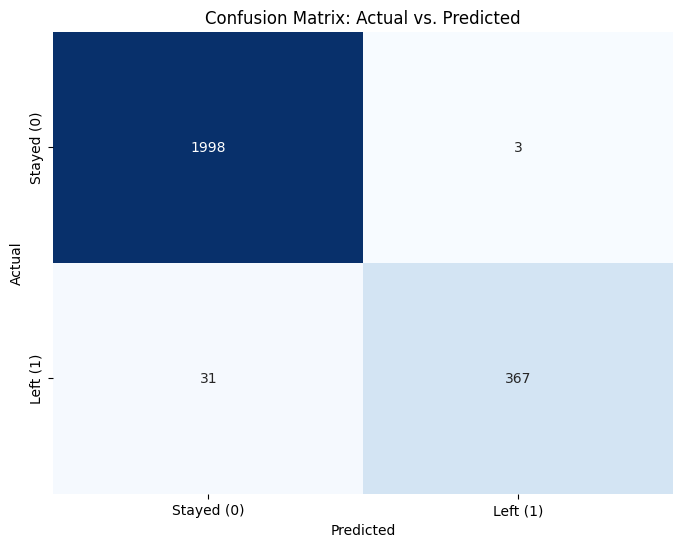

In [380]:
y_pred = pipeline_saved.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Stayed (0)', 'Left (1)'], yticklabels=['Stayed (0)', 'Left (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Actual vs. Predicted')
plt.show()